# Imports and setup

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time




/home/e20220005499/Documents/Face-Swap-M2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [3]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


### classe pour mesurer le temps d'entrainement restant

In [4]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset

In [5]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [114]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)


Building dataset 



# Data Augmentation

In [115]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.dataset = tensor_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = TransformedTensorDataset(train_dataset, transform=data_transform)
test_dataset = TransformedTensorDataset(test_dataset, transform=None)


# Paramètres

In [23]:

EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 100

In [116]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [117]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.9215686321258545
Max pixel value: 1.0
Mean pixel value: 0.04351513087749481


train samples: 65, test samples: 19, nb_classes: 10
train Class 0: 8 samples
train Class 1: 6 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 5 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 1 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


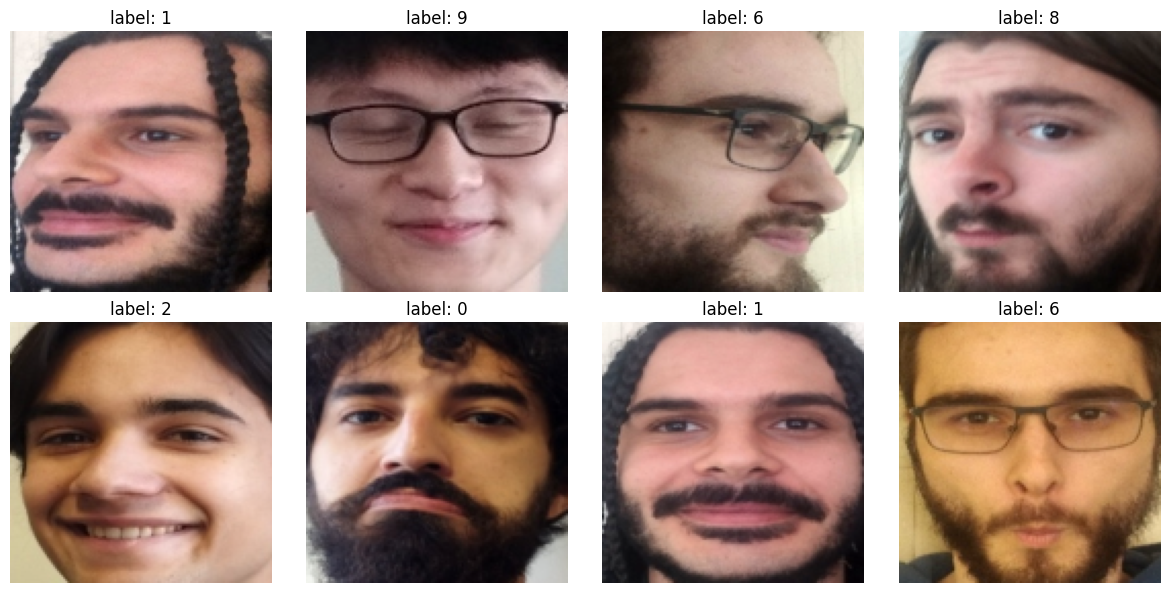

In [107]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [35]:

class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(16 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), EMBEDDING_SIZE)

    def forward(self, x):
        res = self.conv(x)
        res = torch.flatten(res, 1)
        res = self.fc(res)
        res = F.normalize(res, p=2, dim=1)
        return res


class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(EMBEDDING_SIZE, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

        )

    def forward(self, x):
        res = x.unflatten(1, (EMBEDDING_SIZE, 1, 1))
        res = self.decoder(res)
        return res




# Embedding

## Entrainement

In [47]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = TripletMarginLoss(margin=1.0)
miner = BatchHardMiner()
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

final_embedder_loss = 0.0

train_losses = []
val_losses = []

faceEmbedder.train()
for epoch in range(200):

    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)
        #anchors = output[anchor_idx]
        #positives = output[positive_idx]
        #negatives = output[negative_idx]
        #loss = triplet_loss(anchors, positives, negatives)

        triplets = miner(output, labels)

        loss = triplet_loss(output,labels, triplets)

        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)

    faceEmbedder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = faceEmbedder(images)
            #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

            #anchors = output[anchor_idx]
            #positives = output[positive_idx]
            #negatives = output[negative_idx]
            #loss = triplet_loss(anchors, positives, negatives)

            triplets = miner(output, labels)

            loss = triplet_loss(output,labels, triplets)

            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    #val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")
    final_embedder_loss = total_loss
    faceEmbedder.train()


Embedder has 2098720 parameters
Epoch 1, Training Loss: 0.7596, Validation Loss: 1.0874
Epoch 2, Training Loss: 0.7338, Validation Loss: 1.0649
Epoch 3, Training Loss: 0.7285, Validation Loss: 1.0553
Epoch 4, Training Loss: 0.7146, Validation Loss: 1.0467
Epoch 5, Training Loss: 0.6928, Validation Loss: 1.0405
Epoch 6, Training Loss: 0.6999, Validation Loss: 1.0329
Epoch 7, Training Loss: 0.6855, Validation Loss: 1.0267
Epoch 8, Training Loss: 0.6743, Validation Loss: 1.0189
Epoch 9, Training Loss: 0.6683, Validation Loss: 1.0101
Epoch 10, Training Loss: 0.6489, Validation Loss: 1.0034
Epoch 11, Training Loss: 0.6508, Validation Loss: 0.9970
Epoch 12, Training Loss: 0.6419, Validation Loss: 0.9913
Epoch 13, Training Loss: 0.6412, Validation Loss: 0.9877
Epoch 14, Training Loss: 0.6476, Validation Loss: 0.9849
Epoch 15, Training Loss: 0.6327, Validation Loss: 0.9809
Epoch 16, Training Loss: 0.6157, Validation Loss: 0.9770
Epoch 17, Training Loss: 0.5985, Validation Loss: 0.9723
Epoch 18

In [ ]:
torch.save(faceEmbedder.state_dict(), f"embedder_150.pth")

## Analyse

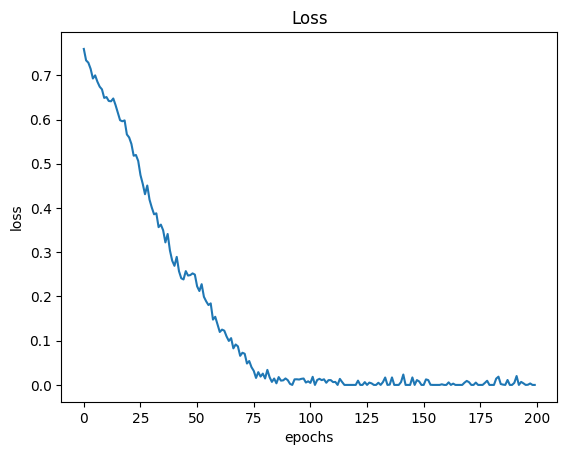

In [48]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Calcul tous les embeddings

In [49]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [0.08774645812809467, 0.03503794223070145, 0.005923617049120367, 0.054211833979934454, 0.03142362704966217, 0.010014243820023694, -0.07041789079084992, 0.08919866196811199, 0.06549478927627206, 0.05409354530274868, 0.03812234755605459, 0.156452264636755, 0.08150689862668514, 0.005585908482316881, -0.042474267596844584, -0.1521699158474803, 0.08164236880838871, -0.04758434044197202, -0.03423592180479318, 0.002402243626420386, 0.11943198461085558, 0.0684170937165618, -0.01961247541476041, 0.08509737346321344, -0.08665052941069007, 0.16784662567079067, 0.16719795018434525, 0.05037226900458336, 0.03260067547671497, 0.14409767650067806, -0.12322369776666164, 0.012318791072175372, 0.02210286573972553, -0.012154271484178025, -0.09591083880513906, -0.050319783156737685, -0.0895268227905035, -0.06434845505282283, 0.13052401132881641, -0.08020688220858574, -0.22159644030034542, -0.15301728155463934, -0.15180987678468227, -0.14467077143490314, 0.014948217023629695, 0.089

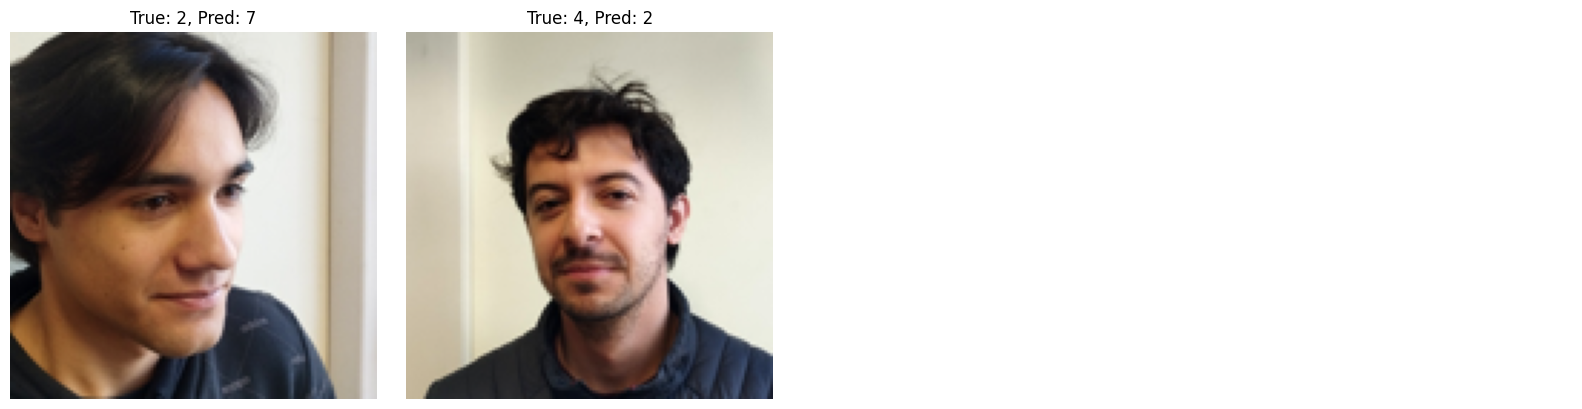

In [44]:
faceEmbedder.eval()

misclassified_images = []
true_labels = []
predicted_labels = []

avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min != labels[0].item():
            misclassified_images.append(images[0].cpu())
            true_labels.append(labels[0].item())
            predicted_labels.append(i_min)


n = len(misclassified_images)
cols = 4
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis("off")
    if i < n:
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
plt.tight_layout()
plt.show()


### Plot embeddings

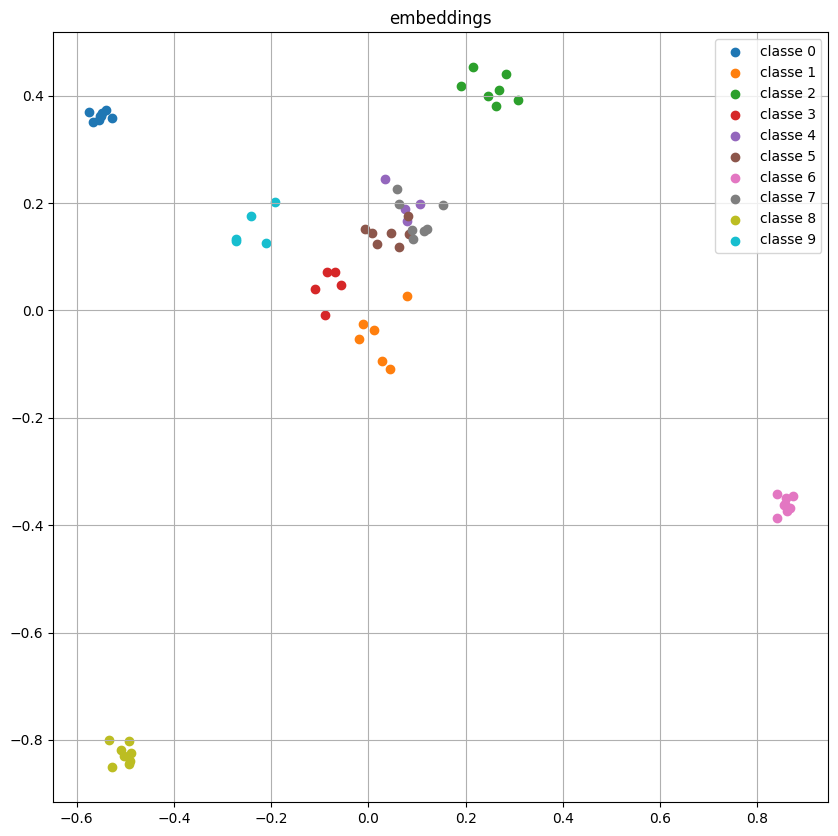

In [46]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [62]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(1250):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 2.3269, test loss: 2.3145
Epoch 2, training loss: 2.2776, test loss: 2.3083
Epoch 3, training loss: 2.3004, test loss: 2.3023
Epoch 4, training loss: 2.2924, test loss: 2.2966
Epoch 5, training loss: 2.2490, test loss: 2.2909
Epoch 6, training loss: 2.2352, test loss: 2.2854
Epoch 7, training loss: 2.2664, test loss: 2.2802
Epoch 8, training loss: 2.2399, test loss: 2.2750
Epoch 9, training loss: 2.2167, test loss: 2.2700
Epoch 10, training loss: 2.2229, test loss: 2.2650
Epoch 11, training loss: 2.1992, test loss: 2.2601
Epoch 12, training loss: 2.2109, test loss: 2.2552
Epoch 13, training loss: 2.2327, test loss: 2.2503
Epoch 14, training loss: 2.1763, test loss: 2.2453
Epoch 15, training loss: 2.2079, test loss: 2.2403
Epoch 16, training loss: 2.1622, test loss: 2.2354
Epoch 17, training loss: 2.2020, test loss: 2.2306
Epoch 18, training loss: 2.1453, test loss: 2.2258
Epoch 19, training loss: 2.1748, test loss: 2.2209
Epoch 20, training loss: 2.1665, test lo

## Analyse

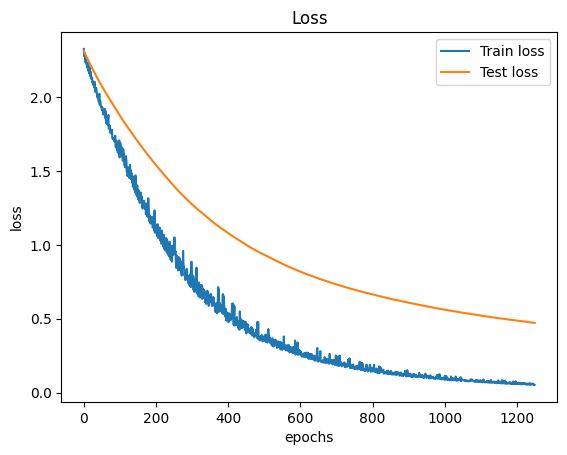

In [63]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

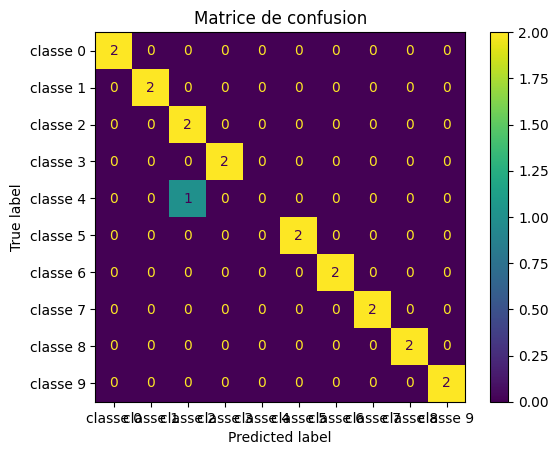

accuracy on test set: 94.74% (18/19)


In [64]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

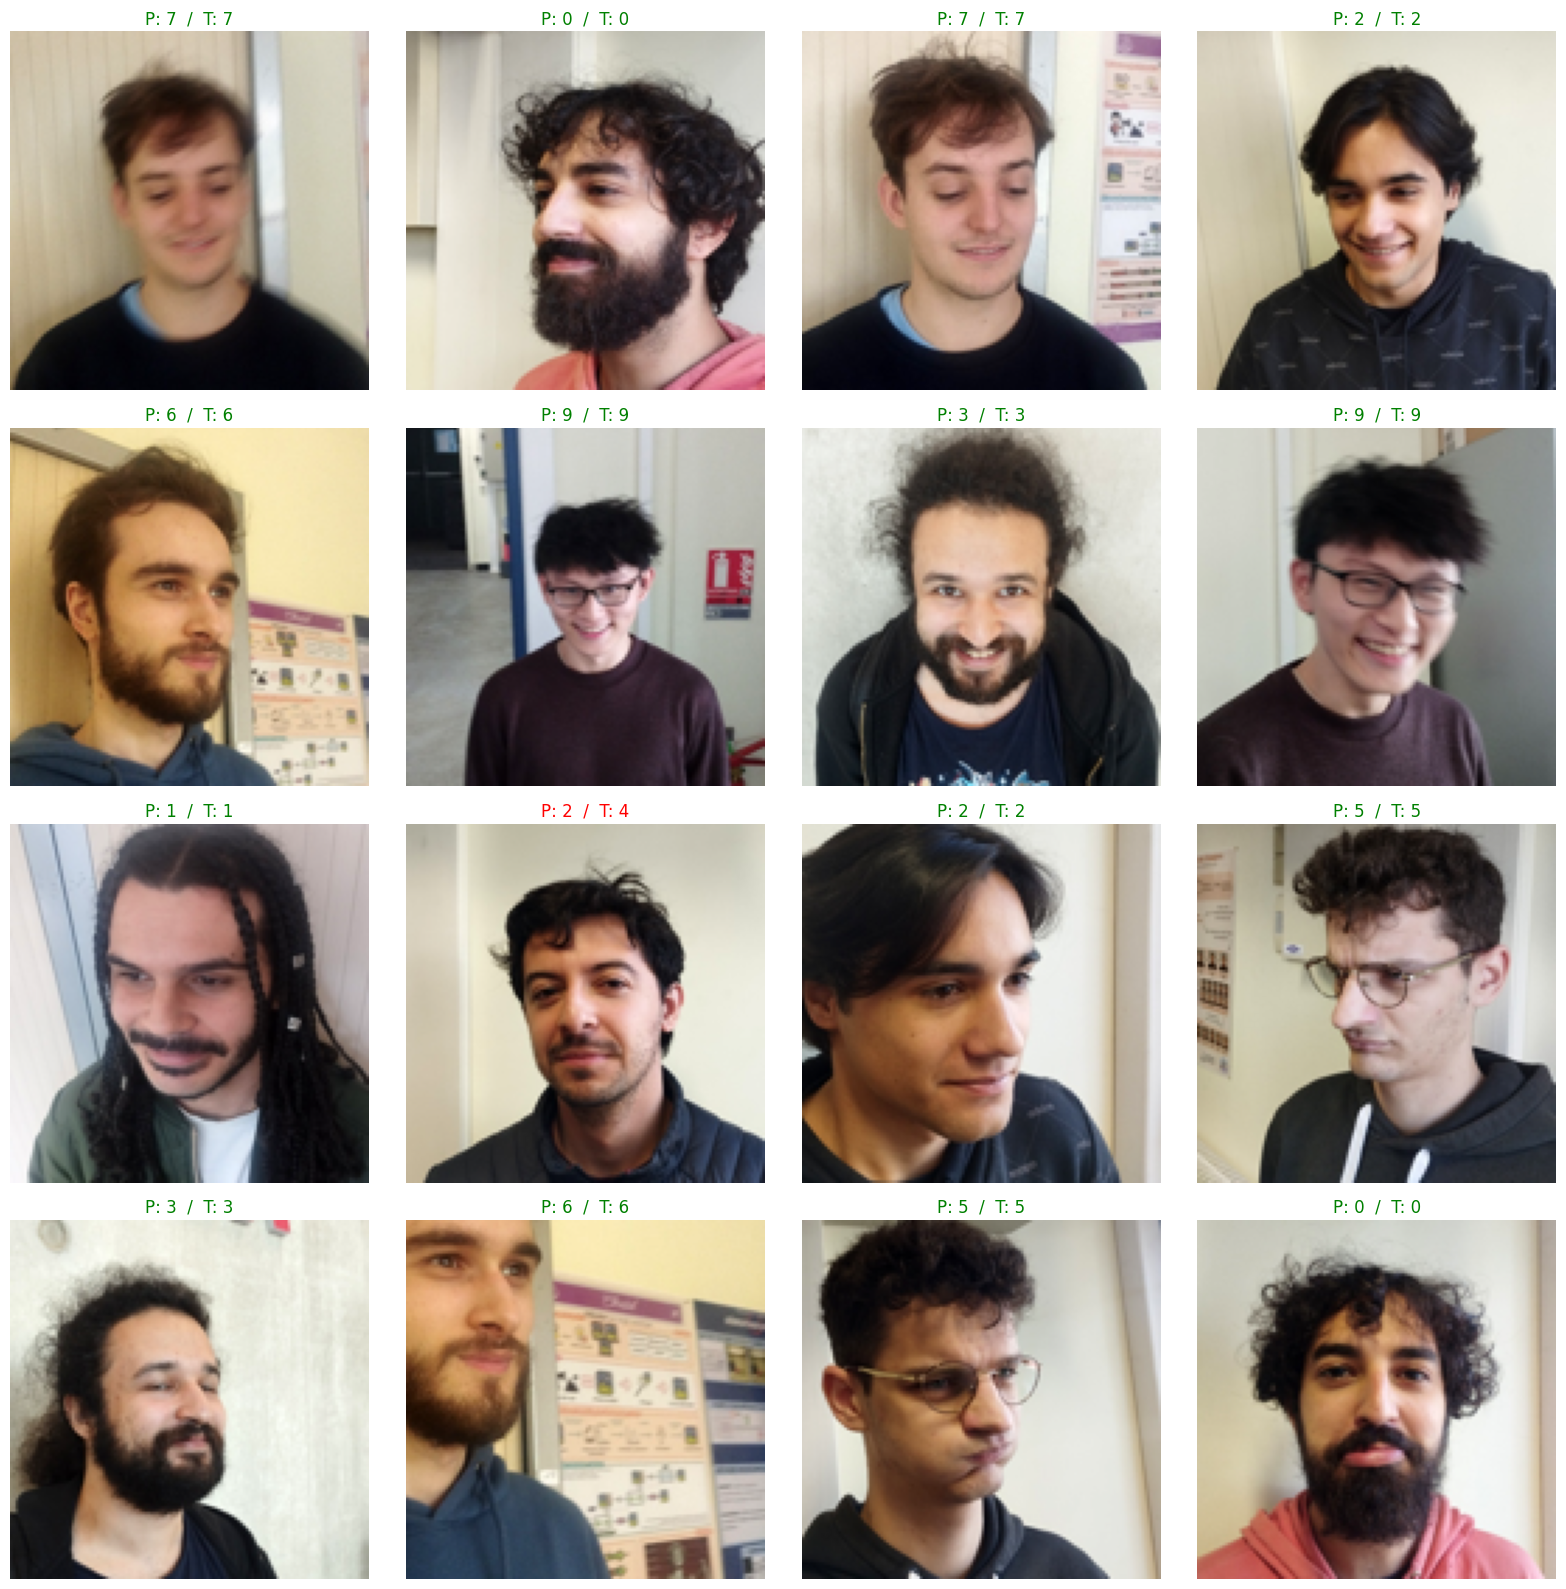

In [67]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

# GAN ahahahahaha

In [136]:
from face_parsing.resnet import *
from face_parsing.bisenet import BiSeNet

def load_model(model_name: str, num_classes: int, weight_path: str, device: torch.device) -> torch.nn.Module:
    """
    Load and initialize the BiSeNet model.

    Args:
        model_name: Name of the backbone model (e.g., "resnet18")
        num_classes: Number of segmentation classes
        weight_path: Path to the model weights file
        device: Device to load the model onto

    Returns:
        torch.nn.Module: Initialized and loaded model
    """
    model = BiSeNet(num_classes, backbone_name=model_name)
    model.to(device)

    if os.path.exists(weight_path):
        model.load_state_dict(torch.load(weight_path, map_location=device))
    else:
        raise ValueError(f"Weights not found from given path ({weight_path})")

    model.eval()
    return model

In [138]:
segmentor = load_model("resnet18", 19,"./models/resnet18.pt", device)
#segmentor.load_state_dict(torch.load("models/resnet18.pt"),)
segmentor = segmentor.to(device)
segmentor.eval()


RuntimeError: Error(s) in loading state_dict for BiSeNet:
	size mismatch for conv_out.conv.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
	size mismatch for conv_out16.conv.weight: copying a param with shape torch.Size([19, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
	size mismatch for conv_out32.conv.weight: copying a param with shape torch.Size([19, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).

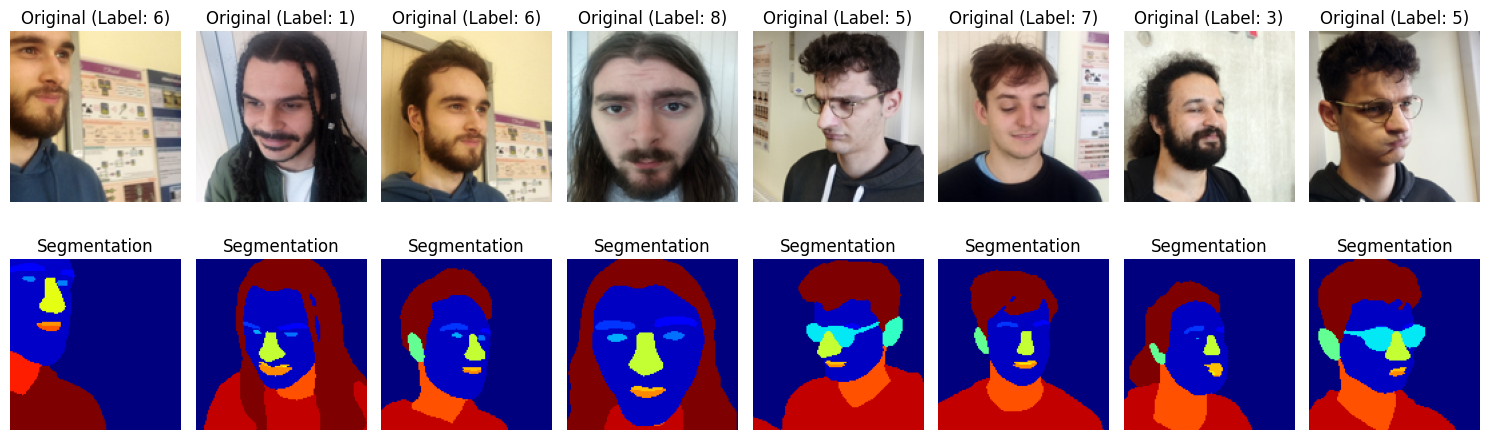

In [ ]:

from torchvision.transforms.functional import to_pil_image

def preprocess_for_segmentor(images, device, target_size=512):
    """
    Prepare a batch tensor for the BiSeNet segmentor.
    - images: torch.Tensor [B,C,H,W], possibly in [-1,1] or [0,1]
    - returns normalized tensor on device with size (B,3,target_size,target_size)
    """
    imgs = images.clone().to(device)
    # if images are in [-1,1], map to [0,1]
    if imgs.min() < -0.5:
        imgs = (imgs + 1.0) / 2.0
    imgs = torch.clamp(imgs, 0.0, 1.0)
    # resize to segmentor expected input (512x512 is common for face parsing)
    imgs = F.interpolate(imgs, size=(target_size, target_size), mode='bilinear', align_corners=False)
    # normalize using ImageNet stats (adjust if your segmentor used different stats)
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    imgs = (imgs - mean) / std
    return imgs

images, labels = next(iter(test_loader))
orig_images = images.clone()  # keep original batch for display
orig_h, orig_w = images.size(2), images.size(3)

prep = preprocess_for_segmentor(images, device, target_size=512)

with torch.no_grad():
    outputs = segmentor(prep)
    # many BiSeNet implementations return a tuple/list where logits are first
    if isinstance(outputs, (list, tuple)):
        seg_logits = outputs[0]
    else:
        seg_logits = outputs

    # seg_logits shape: [B, num_classes, H_seg, W_seg]
    seg = seg_logits.argmax(dim=1, keepdim=True).float()  # [B,1,H_seg,W_seg]
    # resize segmentation map back to original image size using nearest (preserve labels)
    seg_resized = F.interpolate(seg, size=(orig_h, orig_w), mode='nearest').squeeze(1).cpu().numpy()

n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = orig_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
    img_disp = (img - mi) / denom
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    seg_map = seg_resized[i]
    axs[1, i].imshow(seg_map, cmap="jet")
    axs[1, i].set_title("Segmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

In [172]:
from torchvision.transforms.functional import to_pil_image

# Function to extract face embeddings
def extract_face_features(images, embedder, device):
    embedder.eval()
    embeddings = []

    with torch.no_grad():
        images = images.to(device)
        face_embeddings = embedder(images)

        for i in range(images.size(0)):
            # Extract embedding
            embeddings.append(face_embeddings[i].cpu().numpy())

    return embeddings

# Example usage
images, labels = next(iter(test_loader))  # Get a batch of test images
embeddings = extract_face_features(images, faceEmbedder, device)

# Print results
#print("Embeddings:", embeddings)


## Entrainement

In [188]:
# Improved Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.InstanceNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.InstanceNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.InstanceNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size * 3),  # Adjust for RGB images
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 3, self.img_size, self.img_size)  # Adjust for RGB images


# Improved Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * 3, 512),  # Adjust for RGB images
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [189]:
# Hyperparameters
latent_dim = 128
img_size = 128
batch_size = 64
epochs = 1000
lr = 0.0002


generator = Generator(latent_dim, img_size).to(device)
discriminator = Discriminator(img_size).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
adversarial_loss = nn.BCELoss()

In [196]:
for epoch in range(epochs):
    for images, labels in train_loader:
        # Select images of class 0 and other classes explicitly
        class_0_images = images[labels == 0]
        other_class_images = images[labels != 0]
        other_class_labels = labels[labels != 0]

        if class_0_images.size(0) == 0 or other_class_images.size(0) == 0:
            continue

        # Ensure batch size consistency
        batch_size = min(class_0_images.size(0), other_class_images.size(0))
        class_0_images = class_0_images[:batch_size].to(device)
        other_class_images = other_class_images[:batch_size].to(device)
        other_class_labels = other_class_labels[:batch_size].to(device)

        # Extract embeddings for class 0 and other classes
        class_0_embeddings = faceEmbedder(class_0_images).to(device)
        other_class_embeddings = faceEmbedder(other_class_images).to(device)

        # Replace embeddings of other classes with class 0 embeddings
        swapped_embeddings = class_0_embeddings

        # Decode swapped embeddings back to images
        swapped_images = generator(swapped_embeddings)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_loss = adversarial_loss(discriminator(other_class_images), real_labels)
        fake_loss = adversarial_loss(discriminator(swapped_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        g_loss_adv = adversarial_loss(discriminator(swapped_images), real_labels)

        # Classifier loss: make swapped images classified as their original labels
        swapped_embeddings = faceEmbedder(swapped_images)
        classifier_logits = classifier(swapped_embeddings)
        g_loss_cls = crossLoss(classifier_logits, other_class_labels)

        # Total generator loss
        g_loss = g_loss_adv + g_loss_cls

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")



Epoch 0/1000 | D Loss: 0.7171 | G Loss: 2.9704
Epoch 20/1000 | D Loss: 0.7313 | G Loss: 2.7150
Epoch 20/1000 | D Loss: 0.7313 | G Loss: 2.7150


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])

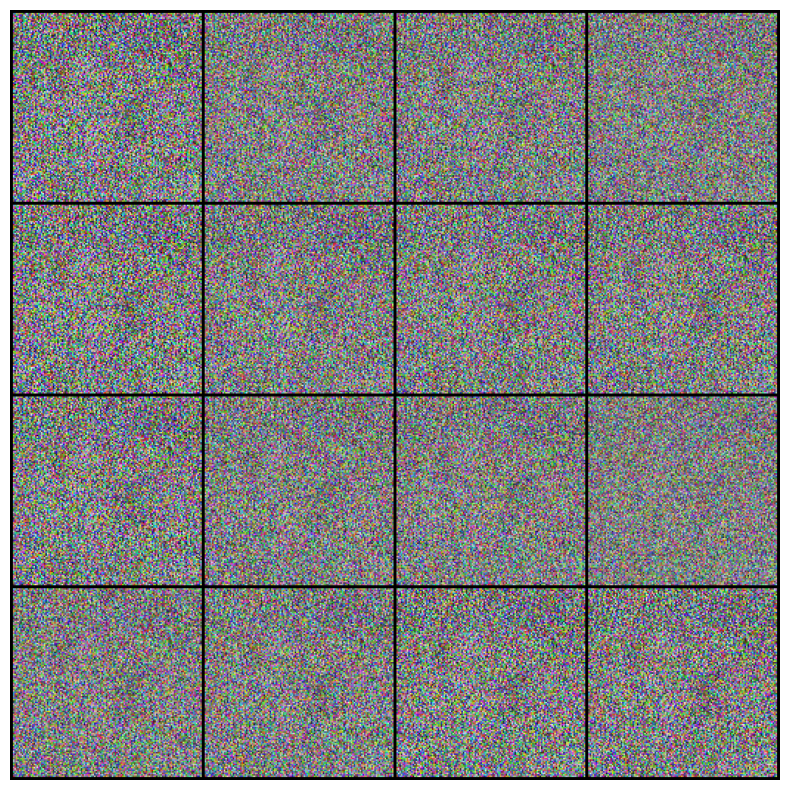

In [191]:
# Generate and visualize swapped images
z = torch.randn(16, latent_dim).to(device)
generated_imgs = generator(z).cpu().detach()
grid = make_grid(generated_imgs, nrow=4, normalize=True)

plt.figure(figsize=(10, 10))  # Increase the figure size
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

# VAE

In [ ]:

EMBEDDING_SIZE = 128

class VAE(nn.Module):
    def __init__(self, embedding = 128):
        super().__init__()
        self.embedding = embedding
        self.max_feature = 16
        self.img_size = 32
        self.flattened_size = self.max_feature * self.img_size * self.img_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1, ), # 3 car image RGB, 6 en sortie (6 filtres) , taille noyau de 5
            nn.BatchNorm2d(8), # empeche le collapse des embeddings
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduit par 2 la taille

            nn.Conv2d(8,16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )


        self.fc_decode = nn.Linear(self.embedding, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )


        self.fc_mu = nn.Linear(self.flattened_size, self.embedding )
        self.fc_logvar = nn.Linear(self.flattened_size, self.embedding )

    def encode(self, x):
        encoded = self.encoder(x)
        f = torch.flatten(encoded,1)
        mean = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self,x):
        mean,logvar = self.encode(x)

        z = self.reparametrize(mean,logvar)
        
        h = self.fc_decode(z)
        

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res, mean, logvar
    
    def random(self):

        z = torch.randn((1, self.embedding), device=next(self.parameters()).device)

        h = self.fc_decode(z)

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res







## Entrainement autoencoder complet

In [ ]:
autoencoder = VAE().to(device)

final_classifier_loss = [0.0,0.0]
losses = []

L1loss = nn.L1Loss()
lpipsLoss = lpips.LPIPS(net='alex').to(device)
lpips_factor = 0.00

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"VAE has {params} parameters")

beta = 1.0

def elbo_loss(recon, x, mean, logvar):
    #lpi_loss = lpipsLoss(recon, x).mean() * lpips_factor 
    recon_loss = (F.l1_loss(recon, x, reduction='sum') )/x.size(0) 
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_loss , recon_loss, beta * kl_loss

In [ ]:

checkpoint_path = "autoencoder_epoch_300.pth"
autoencoder.load_state_dict(torch.load(checkpoint_path))
autoencoder.eval()

In [ ]:
epochs = 250

eta = ETA(epochs)

for epoch in range(epochs):
    eta.update()
    eta.print()
    total_loss = 0.0
    autoencoder.train()
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        z ,recon, mean, logvar = autoencoder(images)

        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean,logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    autoencoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        z ,recon, mean, logvar = autoencoder(images)
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean,logvar)

        total_eval_loss += loss.item()

    scheduler.step()

    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss

    if (epoch + 1) % 50 == 0:
        #torch.save(autoencoder.state_dict(), f"models/autoencoder_epoch_{epoch+1}.pth")
        pass

### Analyse

#### Loss

In [ ]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

#### Encoder

In [ ]:
autoencoder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        emb, output,_,_ = autoencoder(images)

        for i in range(emb.size(0)):
            embeddings.append([emb[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

#### Decoder

#### Sur jeu d'entrainement

In [ ]:
autoencoder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():

    _,reconstructed_images, _,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Sur jeu de test

In [ ]:
autoencoder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _,reconstructed_images,_,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
autoencoder.eval()

reconstructed_images = []

with torch.no_grad():
    for _ in range(8):
        _, img = autoencoder.random()
        reconstructed_images.append(img)

reconstructed_images = torch.cat(reconstructed_images, dim=0)

n = reconstructed_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[i].imshow(recon_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Random {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
autoencoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device, dtype=torch.float32)

random_embeddings = random_embeddings.to(device)

decoder_only = autoencoder.decoder.eval()

with torch.no_grad():
    #un = random_embeddings.unflatten(1, (EMBEDDING_SIZE, 1, 1))
    #generated_images = autoencoder.decoder(random_embeddings)

    h = autoencoder.fc_decode(random_embeddings)
    h = h.view(-1, autoencoder.max_feature, autoencoder.img_size, autoencoder.img_size)
    generated_images = autoencoder.decoder(h)
    

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"class {i+1}")

plt.tight_layout()
plt.show()

#### HYPER LOOP

In [ ]:
from itertools import product

learning_rates = [0.0001, 0.001]
betas = [0.5, 1.0, 2.0]
lpips_factors = [0.0]
batch_sizes = [4,8,16, 32]
weight_decays = [0.0]
latent_sizes = [32,64,128]
epochs = 250

total_models = len(learning_rates) * len(betas) * len(lpips_factors) * len(batch_sizes) * len(weight_decays) * len(latent_sizes)
i = 0

for lr, beta, lpips_factor, batch_size, weight_decay, latent_s in product(learning_rates, betas, lpips_factors, batch_sizes, weight_decays, latent_sizes):
    #print(f"Training VAE with lr={lr}, beta={beta}, lpips_factor={lpips_factor}, batch_size={batch_size}, weight_decay={weight_decay}")
    
    autoencoder = VAE(latent_s).to(device)

    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def elbo_loss(recon, x, mean, logvar):
        recon_loss = (F.l1_loss(recon, x, reduction='sum') / x.size(0)) #+ lpipsLoss(recon, x).mean() * lpips_factor
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
        return recon_loss + beta * kl_loss, recon_loss, beta * kl_loss

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            z, recon, mean, logvar = autoencoder(images)
            loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

    model_name = f"models/vae_lr{lr}_beta{beta}_lpips{lpips_factor}_bs{batch_size}_ls{latent_s}.pth"
    torch.save(autoencoder.state_dict(), model_name)
    print(f"model saved {model_name} ")
    
    print(f"{i}/{total_models}")
    i+=1

In [ ]:
import re

model_dir = "models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]

for model_file in model_files:
    print(f"testing model: {model_file}")
    
    latent_size_match = re.search(r'_ls(\d+)', model_file)
    if latent_size_match:
        latent_size = int(latent_size_match.group(1))
    else:
        print(f"Could not extract latent size from filename: {model_file}")
        continue
    
    autoencoder = VAE(embedding=latent_size).to(device)
    model_path = os.path.join(model_dir, model_file)
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()
    
    total_loss = 0.0
    reconstructed_images = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _, recon, mean, logvar = autoencoder(images)
            loss, _, _ = elbo_loss(recon, images, mean, logvar)
            total_loss += loss.item()
            reconstructed_images.append(recon.cpu())
    
    avg_loss = total_loss / len(test_loader)
    print(f"avg loss on test set: {avg_loss:.4f}")
    
    reconstructed_images = torch.cat(reconstructed_images, dim=0)
    n = min(8, reconstructed_images.size(0))
    fig, axs = plt.subplots(2, n, figsize=(15, 5))
    
    for i in range(n):
        original_img = images[i].permute(1, 2, 0).cpu().numpy()
        recon_img = reconstructed_images[i].permute(1, 2, 0).numpy()
        
        mi, ma = original_img.min(), original_img.max()
        original_disp = (original_img - mi) / (ma - mi) if ma - mi > 1e-6 else original_img
        
        mi, ma = recon_img.min(), recon_img.max()
        recon_disp = (recon_img - mi) / (ma - mi) if ma - ma > 1e-6 else recon_img
        
        axs[0, i].imshow(original_disp)
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")
        
        axs[1, i].imshow(recon_disp)
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    del autoencoder
    torch.cuda.empty_cache()


##     Entrainement du decodeur uniquement avec un embedder deja entraine

In [ ]:
decoder = Decoder().to(device)
L1loss = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(100):
    total_loss = 0.0
    decoder.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)
        #print(images.size())

        output = decoder(embeded)
        #print(output.size())

        loss = L1loss(output, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    decoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = decoder(embeded)
        loss = L1loss(output, images)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



### Analyse

In [ ]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

In [ ]:
decoder.eval()
faceEmbedder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    embeddings = faceEmbedder(images)

    reconstructed_images = decoder(embeddings)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

### Reconstruction de la moyenne des embeddings de chaque classe

In [ ]:
decoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device)

random_embeddings = random_embeddings.to(device)

with torch.no_grad():
    generated_images = decoder(random_embeddings)

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Generated {i+1}")

plt.tight_layout()
plt.show()